# Libraries

In [2]:
import tensorflow as tf
import keras
from keras import preprocessing
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import metrics

from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras import callbacks

# set class weights for neural network training
class_weight = {0: 21, 1: 15, 2: 26, 3: 27, 4: 11}

from contextlib import contextmanager
import sys, os

### for suppressing messages from functions that output a lot into console
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load Data Function

In [2]:
# function that sets up batch loading of normalised training and validation data
def load_data(img_size, omit_unknown):
    
    # decide whether or not to keep unknowns
    if omit_unknown:
        data_dir = '/kaggle/input/train-test-split-no-unknown/Train_Test_Split_no_unknown/Train'
    else:
        data_dir = f'/kaggle/input/train-test-split/Train_Test_Split/Train'

    # make a 60/40 train and validation split. A seed is set so that the results are reproducible.
    # The test data is already held out in a separate location - it will not be touched until
    # the final model is ready to be evaluated
    train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                                        labels='inferred', 
                                                                        label_mode='categorical',
                                                                        batch_size=32,
                                                                        image_size=(img_size, img_size),
                                                                        validation_split = 0.4,
                                                                        subset = "both",
                                                                        seed = 100)

    # pixel normalization
    norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
    norm_train_dataset = train_dataset.map(lambda x, y: (norm_layer(x), y))
    norm_val_dataset = val_dataset.map(lambda x, y: (norm_layer(x), y))
    return(norm_train_dataset, norm_val_dataset)

# Convolutional Neural Network Model

In [3]:
# this function compiles and trains a convolutional neural network with
# input specifications. To prevent overfitting, it will continue to train 
# until the validation accuracy fails to improve twice in a row. Then,
# the weights from the best epoch are returned
def CNN_val_acc(f_dim1, f_dim2, img_size, neurons, dropout, omit_unknown, verb = 0):
    
    train, val = load_data(img_size, omit_unknown)
    
    model = Sequential()
    model.add(Conv2D(f_dim1,3, padding = "same", activation="relu",input_shape=(img_size,img_size,3)))
    model.add(Conv2D(f_dim2,3, padding = "same", activation="relu",input_shape=(img_size,img_size,3)))
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(neurons, activation = "relu"))
    model.add(Dropout(dropout))
    
    if omit_unknown:
        model.add(Dense(4, activation="softmax"))
    else:
        model.add(Dense(5, activation="softmax"))
    
    es = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience = 2,restore_best_weights = True)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train, validation_data=val, epochs=20, callbacks=[es], verbose = verb, class_weight = class_weight)
    val_acc = round(max(history.history['val_accuracy']),3)
    return(val_acc)

# Set the initial values for the hyperparameters of the CNN

In [4]:
# initial hyperparameter values, hyperparameters that favor a simple model are chosen
f_dim1 = 15
f_dim2 = 15
img_size = 24
neuron = 15
dropout = 0.4

# initialise dictionary to store hyperparameter history
hp = {}
hp['f_dim1'] = [f_dim1]
hp['f_dim2'] = [f_dim2]
hp['img_size'] = [img_size]
hp['neuron'] = [neuron]
hp['dropout'] = [dropout]
hp['val_acc'] = [0.34]


# Functions for Tuning Hyperparameters

In [5]:
# function for printing current state of hyperparameters
def print_hypers(hypers, iteration):
    df = pd.DataFrame.from_dict(hypers)
    print("------------------------------------------------------------")
    print("Hyperparameters after Iteration " + str(iteration) + ": ")
    print(df)
    return

# condition on current value of other hyperparameters and perform a grid search
# over a grid for input hyperparameter. If the model can be improved, return the parameters
# that correspond to the simplest model that improves the validation accuracy.
def grid_search(hypers, grid, index, omit_unknown):
    nm = list(hypers.keys())[0:-1] # extract hyperparameter names
    n = len(nm)
    val_accs = [0]*len(grid) # storage for grid search accuracy results
    current_acc = hypers["val_acc"][-1]
    
    # search grid values of parameter to try to increase validation accuracy
    for i in range(len(grid)):
        skip = False
        params = [hp[nm[j]][-1] for j in range(n)]
        
        # if the algorithm tries to test the current value of a parameter, skip
        if params[index] == grid[i]:
            skip = True
            
        params[index] = grid[i]
        
        # no need to test a parameter if it's what the current model is using
        if skip:
            val_accs[i] = current_acc
        else:
            val_accs[i] = CNN_val_acc(params[0], params[1], params[2], params[3], params[4], omit_unknown)
        
        # if an upgrade is found, update the hyperparameter information and end the search
        if val_accs[i] > current_acc:
            for j in range(n):
                hypers[nm[j]] = hypers[nm[j]] + [hypers[nm[j]][-1]]
            hypers[nm[index]][-1] = grid[i]
            hypers["val_acc"] = hypers["val_acc"] + [val_accs[i]]
            return hypers
        
    # if after the whole grid is searched and no improvement is made, end the search
    # and repeat the row
    for j in range(n):
        hypers[nm[j]] = hypers[nm[j]] + [hypers[nm[j]][-1]]
    hypers["val_acc"] = hypers["val_acc"] + [hypers["val_acc"][-1]]
    return hypers
    

# Tune the hyperparameters

In [13]:
# candidate values of hyperparameters to search over
f_dim1_grid = [15, 35, 55, 75]
f_dim2_grid = [15, 35, 55, 75]
img_size_grid = [32, 64, 200, 320]
neurons_grid = [15, 35, 55, 75]
dropout_grid = [0.4,0.5,0.6,0.7]

run = False # set to True when you want to tune hyperparamters. Only needs to be run once (long runtime)
iteration = 0
print_hypers(hp, iteration)

# manually observe the validation accuracy from the print statements
# after the completion of an iteration. If the validation accuracy
# does not improve after 2 iterations (10 rounds of optimisation),
# then stop optimising by "killing" the current run. The hyperparameters
# will be saved
while run:
    hp = grid_search(hp, f_dim1_grid, 0, True)
    hp = grid_search(hp, f_dim2_grid, 1, True)
    hp = grid_search(hp, img_size_grid, 2, True)
    hp = grid_search(hp, neurons_grid, 3, True)
    hp = grid_search(hp, dropout_grid, 4, True)
    iteration = iteration + 1
    print_hypers(hp, iteration)

------------------------------------------------------------
Hyperparameters after Iteration 0: 
   f_dim1  f_dim2  img_size  neuron  dropout  val_acc
0      15      15        24      15      0.4     0.34
Found 11432 files belonging to 4 classes.
Using 6860 files for training.
Using 4572 files for validation.
Found 11432 files belonging to 4 classes.
Using 6860 files for training.
Using 4572 files for validation.
Found 11432 files belonging to 4 classes.
Using 6860 files for training.
Using 4572 files for validation.
Found 11432 files belonging to 4 classes.
Using 6860 files for training.
Using 4572 files for validation.
Found 11432 files belonging to 4 classes.
Using 6860 files for training.
Using 4572 files for validation.
Found 11432 files belonging to 4 classes.
Using 6860 files for training.
Using 4572 files for validation.
Found 11432 files belonging to 4 classes.
Using 6860 files for training.
Using 4572 files for validation.
Found 11432 files belonging to 4 classes.
Using 6860 

KeyboardInterrupt: 

# With the Optimal Hyperparameters Determined, Train the Final Model

In [16]:
# optimal values determined in the previous step:
f_dim1 = 35
f_dim2 = 55
neurons = 75
img_size = 32
dropout = 0.5
omit_unknown = False

# train a model using the optimal parameters
train, val = load_data(img_size, False)

model = Sequential()
model.add(Conv2D(f_dim1,3, padding = "same", activation="relu",input_shape=(img_size,img_size,3)))
model.add(Conv2D(f_dim2,3, padding = "same", activation="relu",input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(neurons, activation = "relu"))
model.add(Dropout(dropout))
model.add(Dense(5, activation="softmax"))

es = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience = 2,restore_best_weights = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, validation_data=val, epochs=20, callbacks=[es], verbose = 1, class_weight = class_weight)


Found 12839 files belonging to 5 classes.
Using 7704 files for training.
Using 5135 files for validation.
Epoch 1/20
241/241 [==============================] - 13s 46ms/step - loss: 31.5547 - accuracy: 0.2992 - val_loss: 1.5458 - val_accuracy: 0.3301
Epoch 2/20
241/241 [==============================] - 12s 49ms/step - loss: 30.3947 - accuracy: 0.3345 - val_loss: 1.4973 - val_accuracy: 0.3451
Epoch 3/20
241/241 [==============================] - 11s 45ms/step - loss: 29.8445 - accuracy: 0.3467 - val_loss: 1.5152 - val_accuracy: 0.3605
Epoch 4/20
241/241 [==============================] - 12s 49ms/step - loss: 28.9868 - accuracy: 0.3705 - val_loss: 1.4834 - val_accuracy: 0.3762
Epoch 5/20
241/241 [==============================] - 11s 46ms/step - loss: 27.8701 - accuracy: 0.4050 - val_loss: 1.5367 - val_accuracy: 0.3605
Epoch 6/20
241/241 [==============================] - 12s 50ms/step - loss: 26.7220 - accuracy: 0.4324 - val_loss: 1.5487 - val_accuracy: 0.3630


# Load the Test Data

In [17]:
# set test directory location
img_size = 32

if omit_unknown:
    data_dir = '/kaggle/input/train-test-split-no-unknown/Train_Test_Split_no_unknown/Test'
else:
    data_dir = f'/kaggle/input/train-test-split/Train_Test_Split/Test'

# load test data, which has not been used for training or tuning
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                                    labels='inferred', 
                                                                    label_mode='categorical',
                                                                    shuffle = False,
                                                                    batch_size=32,
                                                                    image_size=(img_size, img_size),
                                                                    seed = 100)

# pixel scaling for test features
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
norm_test_dataset = test_dataset.map(lambda x, y: (norm_layer(x), y))

Found 2269 files belonging to 5 classes.


# Predict Test Values with Best Model

In [18]:
# make test predictions
test_preds = np.argmax(model.predict(norm_test_dataset), axis = 1)

# extract test labels
test_labels = np.argmax(np.asarray(list(norm_test_dataset.unbatch().map(lambda x, y: y))), axis=1)

# function for converting numbers back into labels
def num_to_label(number):
    if number == 0:
        return "Detached"
    elif number == 1:
        return "Flat"
    elif number == 2:
        return "Semi-Detached"
    elif number == 3:
        return "Terraced"
    else:
        return "Unknown"
    
# convert test predictions and labels back into the actual labels
test_preds = list(map(num_to_label, test_preds))
test_labels = list(map(num_to_label, test_labels))

71/71 [==============================] - 2s 27ms/step


# Test Accuracy

In [19]:
# compute test case accuracy
matches = 0
for i in range(len(test_preds)):
    matches = matches + (test_preds[i] == test_labels[i])
matches / len (test_preds)

0.373732921992067

# Confusion Matrix

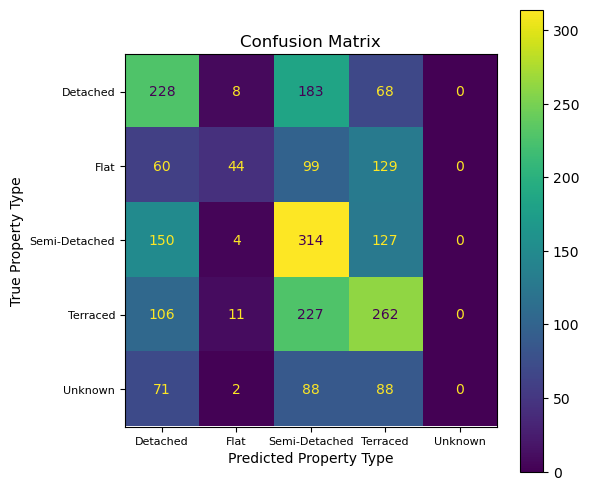

In [20]:
# build a confusion matrix to represent correct vs. incorrect classifications
labels = ["Detached", "Flat", "Semi-Detached", "Terraced", "Unknown"]
result = metrics.confusion_matrix(test_labels, test_preds, labels=labels)
cmatrix = metrics.ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)

# change the font sizes, since they are too large by default
fig, ax = plt.subplots(figsize=(6, 6))
cmatrix.plot(ax=ax)
ax.set_xlabel('Predicted Property Type', fontsize=10)
ax.set_ylabel('True Property Type', fontsize=10)
ax.set_title('Confusion Matrix', fontsize=12)
ax.set_xticklabels(labels, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)
plt.show()

# Compute Precision and Recall Scores per Class

In [78]:
# helper function
def equal(a, b):
    return (a == b)

# precision
def precision(obs, pred, label):
    
    # get indexes of locations of label in predicted values
    indexes = list(map(equal, pred, [label]*len(pred))) 
    obs = pd.DataFrame(obs).loc[indexes]
    correct = 0
    for i in range(len(obs)):
        if obs.iloc[i][0] == label:
            correct = correct + 1
    if len(obs) == 0:
        return("NA")
    return correct / len(obs)


# recall
def recall(obs, pred, label):
    
    # get indexes of locations of label in observed values
    indexes = list(map(equal, obs, [label]*len(obs))) 
    pred = pd.DataFrame(pred).loc[indexes]
    correct = 0
    for i in range(len(pred)):
        if pred.iloc[i][0] == label:
            correct = correct + 1
    return correct / len(pred)


print("Precisions: ")
for i in labels[:-1]:
    print(str(i) + ": " + str(round(precision(test_labels, test_preds, i),3)))
    
print()
print()
    
print("Recall: ")
for i in labels[:-1]:
    print(str(i) + ": " + str(round(recall(test_labels, test_preds, i),3)))
    
# Unknown precision is NA as it doesn't make any unknown classifications
# Unknown recall is 0 for the same reason

Precisions: 
Detached: 0.371
Flat: 0.638
Semi-Detached: 0.345
Terraced: 0.389


Recall: 
Detached: 0.468
Flat: 0.133
Semi-Detached: 0.528
Terraced: 0.432


# Re-train model several times, and make test predictions with it. What kinds of images are consistently classified incorrectly?

In [79]:
# fits the final model
def final_model():

    # optimal values determined in the previous step:
    f_dim1 = 35
    f_dim2 = 55
    neurons = 75
    img_size = 32
    dropout = 0.5
    omit_unknown = False

    # train a model using the optimal parameters
    train, val = load_data(img_size, False)

    model = Sequential()
    model.add(Conv2D(f_dim1,3, padding = "same", activation="relu",input_shape=(img_size,img_size,3)))
    model.add(Conv2D(f_dim2,3, padding = "same", activation="relu",input_shape=(img_size,img_size,3)))
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(neurons, activation = "relu"))
    model.add(Dropout(dropout))
    model.add(Dense(5, activation="softmax"))

    es = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience = 2,restore_best_weights = True)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train, validation_data=val, epochs=20, callbacks=[es], verbose = 1, class_weight = class_weight)
    return model

In [87]:
# extract test labels again
obs = np.argmax(np.asarray(list(norm_test_dataset.unbatch().map(lambda x, y: y))), axis=1)

# initialise storage for keeping track of misclassifications across iterations
misclassifications = np.zeros(len(obs))

# train 10 models, count the misclassifications for each image.
# the unknowns will be misclassified every time - these are not the interesting cases
with suppress_stdout():
    for i in range(10):
        mdl = final_model()
        preds = np.argmax(mdl.predict(norm_test_dataset), axis = 1)
        for j in range(len(preds)):
            if obs[j] != preds[j]:
                misclassifications[j] = misclassifications[j] + 1
    

Found 12839 files belonging to 5 classes.
Using 7704 files for training.
Using 5135 files for validation.
Epoch 1/20
241/241 [==============================] - 14s 51ms/step - loss: 31.9018 - accuracy: 0.2950 - val_loss: 1.5619 - val_accuracy: 0.3285
Epoch 2/20
241/241 [==============================] - 13s 51ms/step - loss: 30.8151 - accuracy: 0.3296 - val_loss: 1.5251 - val_accuracy: 0.3320
Epoch 3/20
241/241 [==============================] - 12s 48ms/step - loss: 29.9936 - accuracy: 0.3537 - val_loss: 1.5287 - val_accuracy: 0.3538
Epoch 4/20
241/241 [==============================] - 13s 53ms/step - loss: 29.2900 - accuracy: 0.3731 - val_loss: 1.4852 - val_accuracy: 0.3720
Epoch 5/20
241/241 [==============================] - 12s 50ms/step - loss: 28.6064 - accuracy: 0.3932 - val_loss: 1.5285 - val_accuracy: 0.3607
Epoch 6/20
71/71 [==============================] - 2s 28ms/step
Found 12839 files belonging to 5 classes.
Using 7704 files for training.
Using 5135 files for validation

# Analyze the Misclassifications

In [ ]:
# there are 249 Unknown properties in the test dataset. They will all be misclassified
# due to reasons that are explained in the dissertation. They are not of interest right
# now, so remove them

if len(misclassifications) == len(obs):
    misclassifications = misclassifications[0:-249] 

# find the indexes of cases that are misclassified in every single model
indexes = (misclassifications == 10)

# save these indexes and examine the images locally

Found 2269 files belonging to 5 classes.
